In [1]:
import networkx as nx
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
# load connectivity matrix
connectivity_m = scipy.io.loadmat('/Users/armanimanov/Desktop/output_connectivity/100206.tt.gz.FreeSurferSeg.mean_length.end.connectivity.mat').get('connectivity')

### remove nodes related to CSF and ventricles

In [3]:
# UNFILITERED
unfiltered = {}
file_path_unfil = "/Users/armanimanov/Desktop/output_connectivity/FreeSurferSeg_ROIs.txt"
with open(file_path_unfil, "r") as file:
    for index, line in enumerate(file):
        key, value = line.strip().split(" ", 1)
        unfiltered[index] = key

# FILTERED
filtered = {}
file_path_fil = "/Users/armanimanov/Desktop/output_connectivity/FreeSurferSeg_ROIs_filtered.txt"
with open(file_path_fil, "r") as file:
    for index, line in enumerate(file):
        key, value = line.strip().split(" ", 1)
        filtered[index] = key

exclusion = {}

# store the excluded ROIs
for index, value in unfiltered.items():
    if value not in filtered.values():
        exclusion[index] = value

In [4]:
connectivity_m = np.delete(connectivity_m, list(exclusion.keys()), axis=0)
connectivity_m = np.delete(connectivity_m, list(exclusion.keys()), axis=1)

In [5]:
# create weighted graph by using matrix values as edge weights
weighted = nx.from_numpy_array(connectivity_m)

# create unweighted graph by using 1 for all non-zero values in the matrix
unweighted = nx.from_numpy_array(np.where(connectivity_m > 0, 1, 0))

# determine the shortest path lengths between all pairs of nodes in both w / uw graphs
paths_w = dict(nx.shortest_path_length(weighted, weight='weight'))
paths_uw = dict(nx.shortest_path_length(unweighted), weight=None)

### verify there are differences between weighted and unweighted

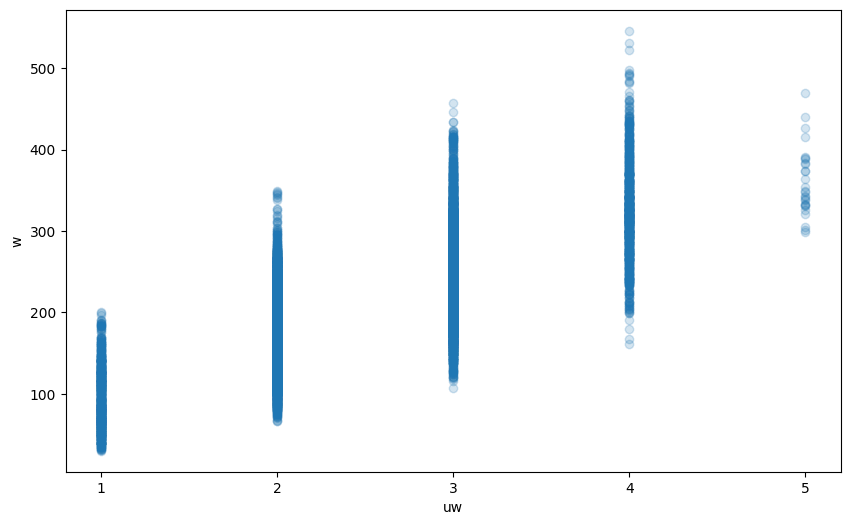

In [6]:
lengths_w = []
lengths_uw = []
node_pairs = []

for origin_node in paths_w:
    for target_node, length in paths_w[origin_node].items():
        if origin_node != target_node:  # don't want paths to self
            lengths_w.append(length)
            lengths_uw.append(paths_uw[origin_node][target_node])
            node_pairs.append((origin_node+1, target_node+1)) #adding 1 to account for index starting at 0

# scatterplot of shortest path lengths
plt.figure(figsize=(10, 6))
plt.scatter(lengths_uw, lengths_w, alpha=0.1)
plt.xlabel('uw')
plt.ylabel('w')
plt.xticks(range(int(min(lengths_uw)), int(max(lengths_uw))+1))
plt.show()



### Gather info on paths that are 2-hop and *shorter* than 1-hop

In [7]:
# dict mapping node numbers to names

node_names = {}

with open(file_path_unfil, "r") as file:
    for index, line in enumerate(file):
        key, value = line.strip().split(" ", 1)
        node_names[index] = value

In [15]:
# find betweenness centrality for uw / w 
uw_centrality = nx.betweenness_centrality(unweighted, weight=None)
w_centrality = nx.betweenness_centrality(weighted, weight='weight')

# sort regions by centrality, largest --> smallest
sorted_unweighted_centrality = sorted(uw_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_weighted_centrality = sorted(w_centrality.items(), key=lambda x: x[1], reverse=True)

unweighted_centrality_list = [(node_names[node], centrality) for node, centrality in sorted_unweighted_centrality]
weighted_centrality_list = [(node_names[node], centrality) for node, centrality in sorted_weighted_centrality]

# table creation
table_data = []
for i in range(len(unweighted_centrality_list)):
    region = unweighted_centrality_list[i][0]
    unweighted_centrality = unweighted_centrality_list[i][1]
    weighted_centrality = weighted_centrality_list[i][1]
    table_data.append([region, unweighted_centrality, weighted_centrality])

headers = ["Region", "Unweighted Centrality", "Weighted Centrality"]
table = tabulate(table_data, headers, tablefmt="grid")

print("Regions sorted by betweenness centrality:")
print(table)

Regions sorted by betweenness centrality:
+----------------------------------+-------------------------+-----------------------+
| Region                           |   Unweighted Centrality |   Weighted Centrality |
+==================================+=========================+=======================+
| WM-hypointensities               |             0.0915195   |           0.118437    |
+----------------------------------+-------------------------+-----------------------+
| Right-choroid-plexus             |             0.0811133   |           0.0960935   |
+----------------------------------+-------------------------+-----------------------+
| ctx_lh_S_pericallosal            |             0.077871    |           0.0938299   |
+----------------------------------+-------------------------+-----------------------+
| Left-Thalamus-Proper             |             0.0592515   |           0.0829135   |
+----------------------------------+-------------------------+-----------------------+
|